In [1]:
%matplotlib inline

import pickle
import pymc3 as pm
import numpy as np
import arviz as az
import matplotlib.pyplot as plt
import theano.tensor as tt
import theano
from scipy.stats import multinomial, norm
from typing import List

np.random.seed(0)

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


# Tutorial on POMDP inference and solution

In this tutorial we will see how to infer a POMDP model, namely the parameters that compose the transition dynamics and the observation generating process, entirely from trajectories of observations and action (states are not observed). Then, we solve the POMDP model via the $Q_{MDP}$ method.

## 1. POMDP true model and data generation

As for the MDP case, we first define the POMDP true model and sample trajectories from it for the inference.

In [2]:
n_states = 3
n_actions = 2

p_init = np.array([1/3., 1/3., 1/3.])

p_transition_0 = np.array(
    [[0.90, 0.09, 0.01],
     [0.01, 0.90, 0.09],
     [0.01, 0.05, 0.94]]
)
p_transition_1 = np.array(
    [[1.  , 0.  , 0.  ],
     [0.9 , 0.1 , 0.  ],
     [0.49, 0.5 , 0.01]]
)
p_transitions = np.array([p_transition_0, p_transition_1])
p_transitions

array([[[0.9 , 0.09, 0.01],
        [0.01, 0.9 , 0.09],
        [0.01, 0.05, 0.94]],

       [[1.  , 0.  , 0.  ],
        [0.9 , 0.1 , 0.  ],
        [0.49, 0.5 , 0.01]]])

Additionally, we now also have an observation generating process and the parameters associated. We assume that the observations are continuous, for which many POMDP solvers cannot be used, while the $Q_{MDP}$ method is not affected. In particular, the observations are sampled by Gaussian likelihoods with state-dependent parameters, i.e., $o_t\sim\mathcal{N}(\mu_{s_t}, \sigma_{s_t})$

In [3]:
mus = [1, 0., -1]
sigmas = [1, 0.5, 0.2]

def gaussian_emissions(states: List[int], mus: List[float], sigmas: List[float]) -> List[float]:
    "True observation model (Gaussian)"
    emissions = []
    for state in states:
        e = norm.rvs(loc=mus[state], scale=sigmas[state])
        emissions.append(e)
    return emissions

We define the functions to sample our trajectories from the POMDP model:

In [4]:
def mdp_sequence(p_init: np.array, p_actions:np.array, p_transitions: np.array, horizon: int) -> List[int]:
    """
    Generate a Markov Decision Process sequence based on p_init, p_actions and p_transitions.
    """
    initial_state = list(multinomial.rvs(1, p_init)).index(1)
    initial_action = list(multinomial.rvs(1, p_actions)).index(1)

    states = [initial_state]
    actions = [initial_action]
    for _ in range(horizon - 1):
        p_tr = p_transitions[actions[-1], states[-1]]
        new_state = list(multinomial.rvs(1, p_tr)).index(1)
        new_action = list(multinomial.rvs(1, p_actions)).index(1)
        states.append(new_state)
        actions.append(new_action)
    return states, actions

def generate_multiple_pomdp_seq(
        horizon: int, number_trajectories: int, p_transitions: np.array, p_init, p_actions: np.array, mus: List[int], sigmas: List[int]
): 
    """
    Generate multiple POMDP sequences.
    """
    #Generating a Markov Sequence
    states_all_seq = np.full((number_trajectories, horizon), np.nan)
    actions_all_seq = np.full((number_trajectories, horizon), np.nan)
    for i in range(number_trajectories):
        states, actions = mdp_sequence(p_init, p_actions, p_transitions, horizon)
        states_all_seq[i, :] = states
        actions_all_seq[i, :] = actions
    states_all_seq = states_all_seq.astype(int)
    actions_all_seq = actions_all_seq.astype(int)
    # Generate Emissions: states and observables
    emissions_all_seq = np.full((number_trajectories, horizon), np.nan)
    for i in range(number_trajectories):
        emissions = gaussian_emissions(states_all_seq[i, :], mus, sigmas)
        emissions_all_seq[i, :] = emissions
    return states_all_seq, emissions_all_seq, actions_all_seq

We generate 10 trajectories and plot the first one:

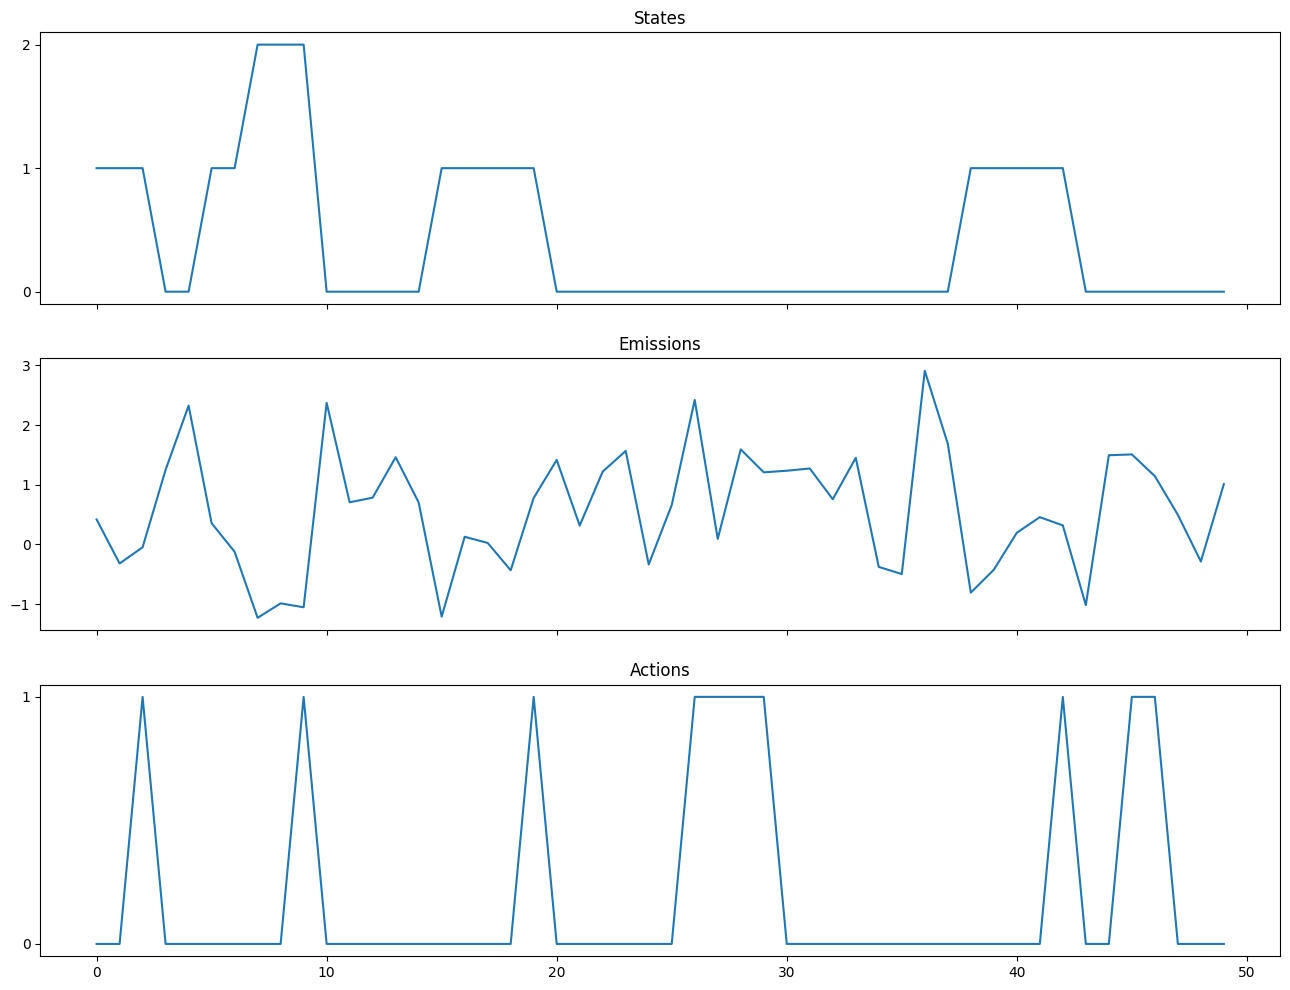

In [5]:
horizon = 50
number_trajectories = 10
p_actions = np.array([0.8, 0.2])

states_all_seq, emissions_all_seq, actions_all_seq = generate_multiple_pomdp_seq(
    horizon, number_trajectories, p_transitions, p_init, p_actions, mus, sigmas
)

fig, axes = plt.subplots(figsize=(16, 12), nrows=3, ncols=1, sharex=True)
axes[0].plot(states_all_seq[0])
axes[0].set_title("States")
axes[0].set_yticks([0, 1, 2])
axes[1].plot(emissions_all_seq[0])
axes[1].set_title("Emissions")
axes[2].plot(actions_all_seq[0])
axes[2].set_title("Actions")
axes[2].set_yticks([0, 1])
plt.show()

## 2. POMDP Inference

The POMDP model parameters are inferred from the trajectories of observations and actions via MCMC sampling of a Hidden Markov Model (HMM) conditioned on actions. We define the HMM states with categorical distributions:

In [6]:
class HMMStates(pm.Categorical):
    def __init__(self, p_transition, init_prob, actions, n_states, *args, **kwargs):
        super(pm.Categorical, self).__init__(*args, **kwargs)
        self.p_transition = p_transition
        self.init_prob = init_prob
        self.actions = actions
        self.k = n_states
        self.mode = tt.cast(0,dtype='int64')

    def logp(self, x):
        p_init = self.init_prob
        acts = self.actions[:-1]
        p_tr = self.p_transition[acts, x[:-1]]

        # the logp of the initial state 
        initial_state_logp = pm.Categorical.dist(p_init).logp(x[0])

        # the logp of the rest of the states.
        x_i = x[1:]
        ou_like = pm.Categorical.dist(p_tr).logp(x_i)
        transition_logp = tt.sum(ou_like)
        return initial_state_logp + transition_logp

And our observation model with Gaussian likehoods:

In [7]:
class GaussianEmissions(pm.Continuous):
    def __init__(self, states, mu, sigma, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.states = states
        self.sigma = sigma 
        self.mu = mu

    def logp(self, x):
        """
        x: observations
        """
        states = self.states
        mu = self.mu[states]
        sigma = self.sigma[states]

        like = tt.sum(pm.Normal.dist(mu=mu[1:], sigma=sigma[1:]).logp(x[1:])) 

        boundary_like = pm.Normal.dist(mu=mu[0], sigma=sigma[0]).logp(x[0])
        return like + boundary_like

And finally the entire HMM: 
- transition matrices and initial probability distribution are modelled via Dirichlet distributions. A completely flat prior is given to all parameters via the $\alpha$ hyperparameter in order to demonstrate that our inference methods are able to recover good estimates even when no prior knowledge is given. In general, it is better to assign more strongly regularizing priors to facilitate the inference.
- $\mu$ is given a Normal prior. We only assign decreasing values to the priors in order to keep the same order of the states during inference (i.e., state 0 produces on average greater valued emissions than state 1, etc...) for the purpose of the tutorial.
- $\sigma$ is given an Exponential prior, flat over all three dimensions again to demonstrate that accurate estimates will be inferred even in absence of prior knowledge. We again recommend use of regularizing informative priors in general. 

The continuous parameters are sampled via the NUTS algorithm, while the discrete hidden states are inferred with Gibbs sampling (default in pymc3). We run 4 parallel chains with 2000 collected samples per chain, for a total of 8000 MCMC samples.

It should be noted that only the sequences of observations and actions are passed to the model for the parameter inference, while the ground truth hidden states are never accessed.

In [8]:
with pm.Model() as pomdp_model:
    transition_mat = pm.Dirichlet(
        "p_transition",
        a=tt.ones((n_actions, n_states, n_states)), # hyperparmeter alpha
        shape=(n_actions, n_states, n_states))
    
    init_probs = pm.Dirichlet('init_probs', a = tt.ones((n_states,)), shape=n_states)
    
    # Prior for mu and sigma
    μ = pm.Normal("mu", mu=[0.5, 0., -0.5], sigma=1, shape=(n_states,)) 
    σ = pm.Exponential("sigma", lam=2, shape=(n_states,))
    
    for i in range(number_trajectories):
        # HMM state
        hmm_states_i = HMMStates(
            "hmm_states_" + str(i),
            p_transition=transition_mat,
            init_prob=init_probs,
            actions=actions_all_seq[i, :],
            n_states=n_states,
            shape=(horizon,)
        )


        # Observed emission likelihood
        obs_i = GaussianEmissions(
            "emission_i" + str(i),
            states=hmm_states_i,
            mu=μ,
            sigma=σ,
            observed=np.array(emissions_all_seq[i, :]).astype("float")
        )
        
    nuts_step = pm.NUTS([pomdp_model.sigma, pomdp_model.mu, pomdp_model.p_transition, pomdp_model.init_probs], target_accept=0.9) 
    trace = pm.sample(2000, tune=3000, step=[nuts_step], chains=4, cores=4, progressbar=True)

/tmp/ipykernel_6569/457570782.py:35: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  trace = pm.sample(2000, tune=3000, step=[nuts_step], chains=4, cores=4, progressbar=True)
Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>NUTS: [init_probs, p_transition, mu, sigma]
>CategoricalGibbsMetropolis: [hmm_states_9, hmm_states_8, hmm_states_7, hmm_states_6, hmm_states_5, hmm_states_4, hmm_states_3, hmm_states_2, hmm_states_1, hmm_states_0]


Sampling 4 chains for 3_000 tune and 2_000 draw iterations (12_000 + 8_000 draws total) took 6268 seconds.
/home/garcieri/.local/lib/python3.8/site-packages/arviz/stats/diagnostics.py:561: RuntimeWarning: invalid value encountered in double_scalars
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
The number of effective samples is smaller than 10% for some parameters.


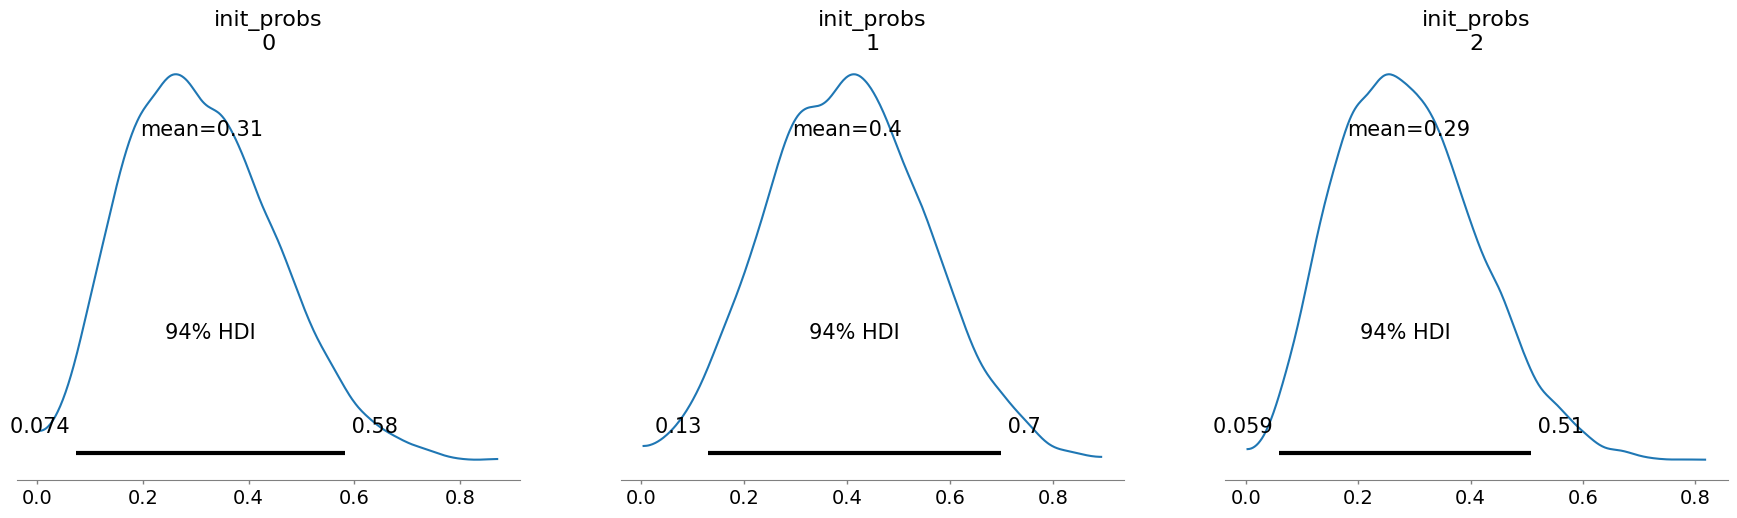

In [10]:
with pomdp_model:
    az.plot_posterior(trace,  var_names=["init_probs"]);

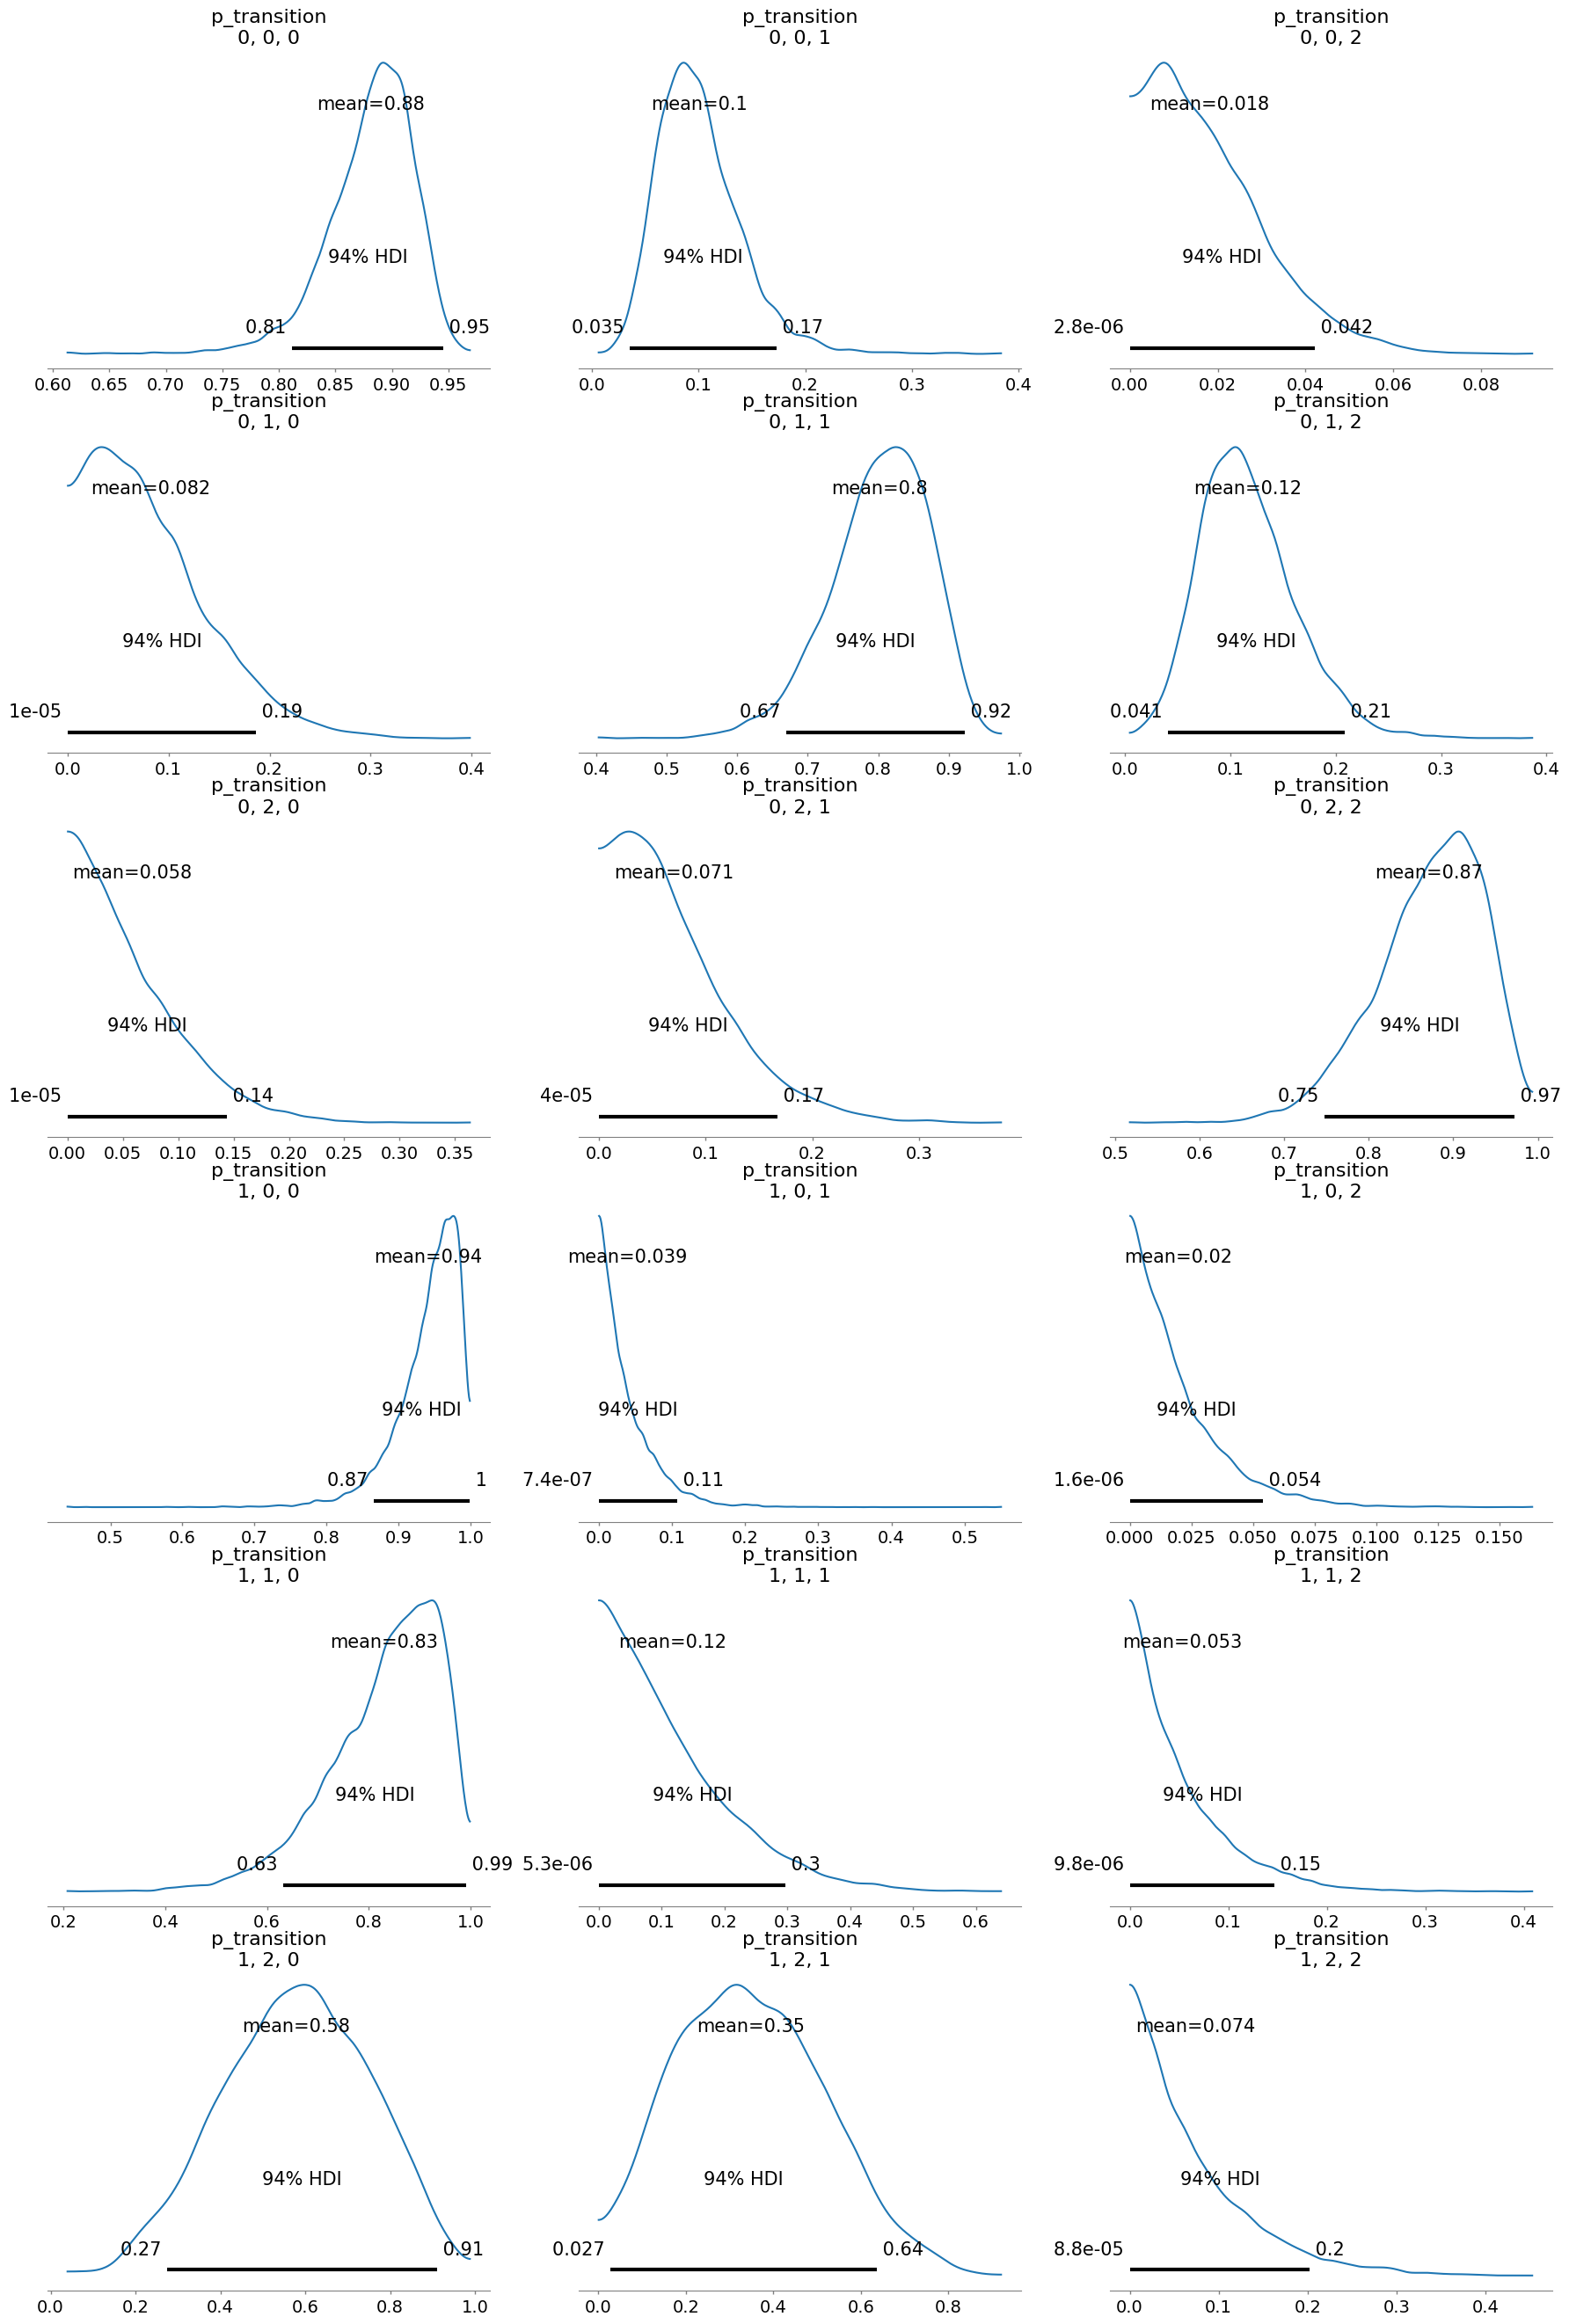

In [11]:
with pomdp_model:
    az.plot_posterior(trace,  var_names=["p_transition"]);

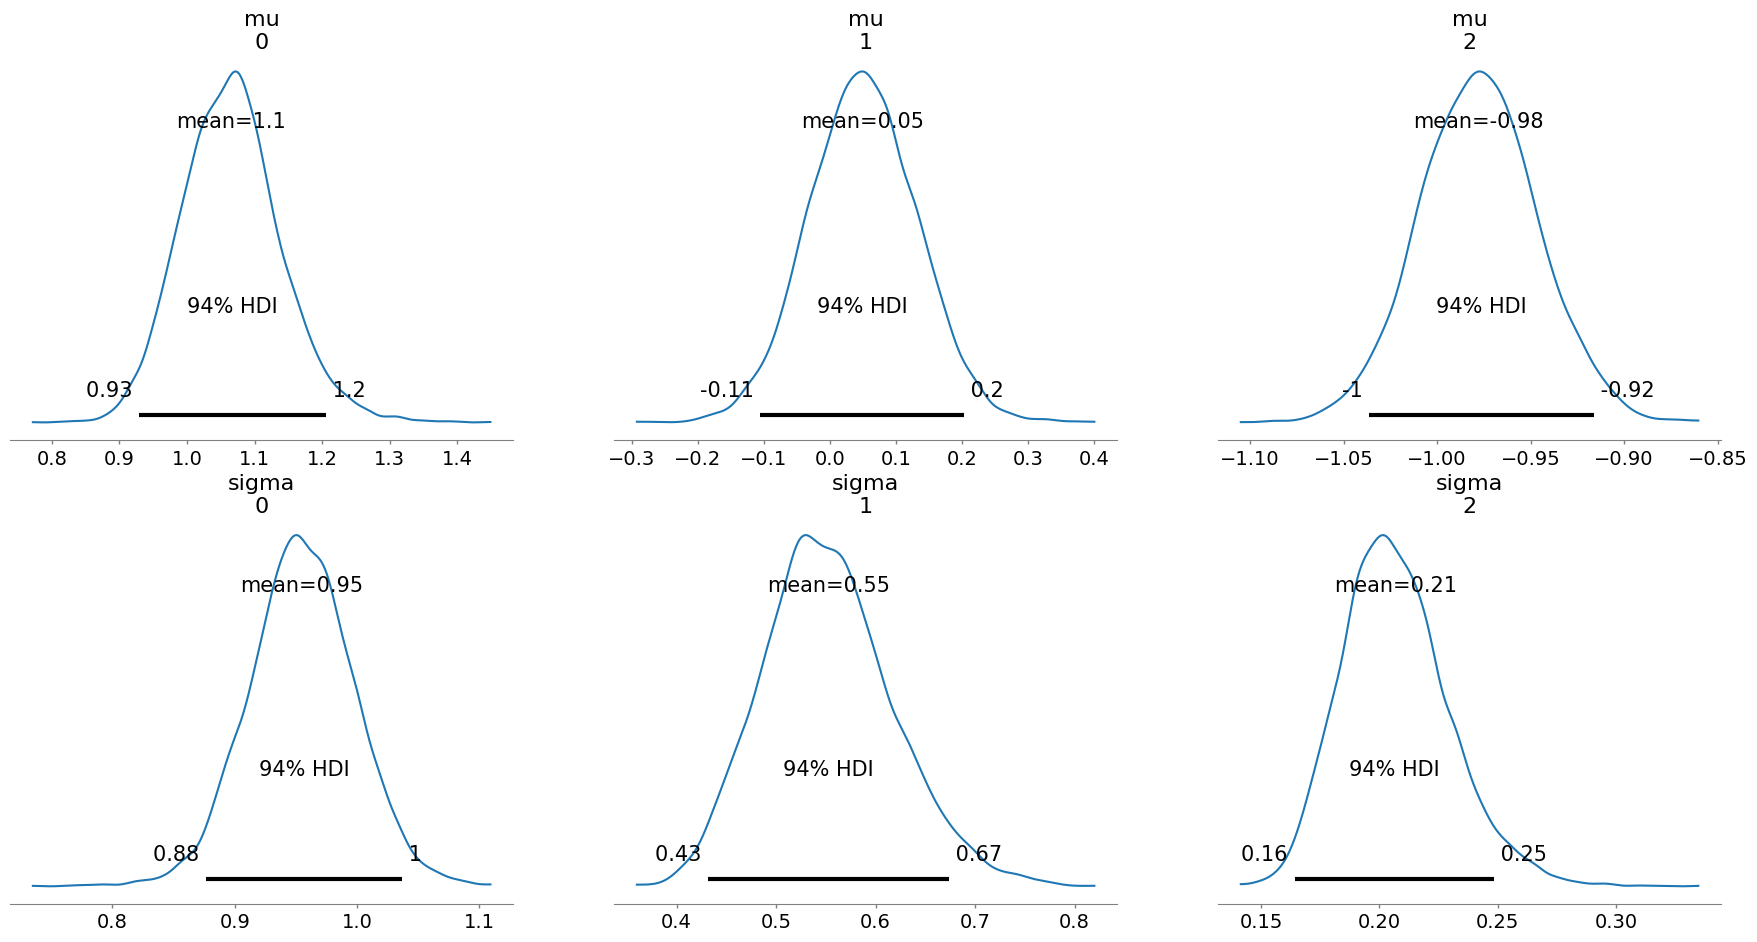

In [12]:
with pomdp_model:
    az.plot_posterior(trace,  var_names=["mu", "sigma"]);

In [13]:
#pomdp_parameters = {}
#pomdp_parameters["inferred_p_init"] = trace["init_probs"]
#pomdp_parameters["inferred_p_transitions"] = trace["p_transition"]
#pomdp_parameters["inferred_mu"] = trace["mu"]
#pomdp_parameters["inferred_sigma"] = trace["sigma"]
#
#file = 'pomdp_parameters.pickle'
#with open(file, "wb") as fp:
#    pickle.dump(pomdp_parameters, fp)

In [14]:
file = 'pomdp_parameters.pickle'
with open(file, "rb") as fp:
    pomdp_parameters = pickle.load(fp)

inferred_p_init_mean = pomdp_parameters["inferred_p_init"].mean(0)
inferred_p_transitions_mean = pomdp_parameters["inferred_p_transitions"].mean(0)
inferred_mu_mean = pomdp_parameters["inferred_mu"].mean(0)
inferred_sigma_mean = pomdp_parameters["inferred_sigma"].mean(0)

Let us compare the ground truth parameters with the inferred mean parameters:

In [15]:
print(f"Ground truth initial state probabilities:\n{p_init}")
print(f"Inferred mean state initial state probabilities:\n{inferred_p_init_mean.round(2)}")

Ground truth initial state probabilities:
[0.33333333 0.33333333 0.33333333]
Inferred mean state initial state probabilities:
[0.31 0.4  0.29]


In [16]:
print(f"Ground truth transition matrices:\n{p_transitions}")
print(f"Inferred mean transition matrices:\n{inferred_p_transitions_mean.round(2)}")

Ground truth transition matrices:
[[[0.9  0.09 0.01]
  [0.01 0.9  0.09]
  [0.01 0.05 0.94]]

 [[1.   0.   0.  ]
  [0.9  0.1  0.  ]
  [0.49 0.5  0.01]]]
Inferred mean transition matrices:
[[[0.88 0.1  0.02]
  [0.08 0.8  0.12]
  [0.06 0.07 0.87]]

 [[0.94 0.04 0.02]
  [0.83 0.12 0.05]
  [0.58 0.35 0.07]]]


In [17]:
print(f"Ground truth mu:\n{mus}")
print(f"Inferred mean mu:\n{inferred_mu_mean.round(2)}")

Ground truth mu:
[1, 0.0, -1]
Inferred mean mu:
[ 1.07  0.05 -0.98]


In [18]:
print(f"Ground truth sigma:\n{sigmas}")
print(f"Inferred mean sigma:\n{inferred_sigma_mean.round(2)}")

Ground truth sigma:
[1, 0.5, 0.2]
Inferred mean sigma:
[0.95 0.55 0.21]


Some probabilities of the transition matrices are further from the ground truth, compared to the MDP, as a result of the more difficult inference task, but the results are still great!

## 3. POMDP solution

In [19]:
# Define rewards
reward_a_0 = - 0
reward_a_1 = - 200 


reward_s_0 = - 10
reward_s_1 = - 100
reward_s_2 = - 800

# Define reward matrix where entry ij is the reward of taking action i at state j
reward_matrix = np.asarray([
    [reward_a_0 + reward_s_0, reward_a_0 + reward_s_1, reward_a_0 + reward_s_2],
    [reward_a_1 + reward_s_0, reward_a_1 + reward_s_1, reward_a_1 + reward_s_2],
])

reward_matrix

array([[  -10,  -100,  -800],
       [ -210,  -300, -1000]])

We now compute the solution of the POMDP with the $Q_{MDP}$ method. For the computation of the Q-values, we can use the same functions of the MDP case (report the Bellman operator computation).

In [20]:
def bellmanOperator(transition_matrices, reward_matrix, V):
    A, S = reward_matrix.shape 
    Q = np.empty((A, S))
    for a in range(A):

        ### TASK: write here your solution
        Q[a] = reward_matrix[a, :] + transition_matrices[a].dot(V) 
        
    return Q, Q.max(axis=0)

def finite_horizon_q_values(transition_matrices, reward_matrix, N): # N is the horizon
    A, S = reward_matrix.shape 
    Q = np.empty((A, S , N))
    V = np.zeros((S, N+1))
    for i in range(N):
        q, v = bellmanOperator(transition_matrices, reward_matrix, V[:, N - i])
        stage = N - i - 1
        V[:, stage] = v
        Q[:, :, stage] = q
    return Q

In [23]:
q_values = finite_horizon_q_values(
    transition_matrices=inferred_p_transitions_mean, reward_matrix=reward_matrix, N=50
)

In addition, we need to define the belief update through Bayes theorem:

<span style="color:red"><ins>Task: </ins></span> Define the belief update.

In [22]:
def belief_update(belief, action, observation, transition_matrices, mus, sigmas):

    ### TASK: write here your solution
    next_belief_prior = transition_matrices[action].T @ belief

    ### TASK: write here your solution
    obs_likelihood = norm.pdf(observation, loc=np.asarray(mus), scale=np.asarray(sigmas))

    ### TASK: write here your solution
    unnorm_next_belief = obs_likelihood * next_belief_prior  # likelihood * prior

    next_belief = unnorm_next_belief/np.sum(unnorm_next_belief)  # normalize

    return next_belief

We can now compute and test our policy:

<span style="color:red"><ins>Task: </ins></span> Compute the optimal action.

In [26]:
tot_rewards = 0
state = multinomial.rvs(1, p_init).argmax() # Sample from true model
observation = norm.rvs(loc=mus[state], scale=sigmas[state])
belief = inferred_p_init_mean # belief initialized with initial prob distribution
for timestep in range(50):

    ### TASK: write here your solution
    action = np.sum(q_values[:, :, timestep]*belief.reshape(1,-1), 1).argmax()
    
    reward = reward_matrix[action, state]
    p_tr = p_transitions[action, state] # Sample from true model
    print(f"Timestep {timestep}\nState {state}\nObservation {observation}\nBelief {belief.round(2)}\nAction {action}\nReward {reward}\n")
    state = multinomial.rvs(1, p_tr).argmax()
    observation = norm.rvs(loc=mus[state], scale=sigmas[state])
    belief = belief_update(belief, action, observation, inferred_p_transitions_mean, inferred_mu_mean, inferred_sigma_mean)
    tot_rewards += reward
print(f"Total rewards {tot_rewards}\n")

Timestep 0
State 0
Observation 0.6767892010343617
Belief [0.31 0.4  0.29]
Action 1
Reward -210

Timestep 1
State 0
Observation 1.195330749764621
Belief [0.96 0.04 0.  ]
Action 0
Reward -10

Timestep 2
State 0
Observation -0.23707399659153294
Belief [0.63 0.37 0.  ]
Action 0
Reward -10

Timestep 3
State 0
Observation 1.3442461790441438
Belief [0.93 0.07 0.  ]
Action 0
Reward -10

Timestep 4
State 0
Observation 0.8479058478518329
Belief [0.9 0.1 0. ]
Action 0
Reward -10

Timestep 5
State 0
Observation 0.011750790956105761
Belief [0.6 0.4 0. ]
Action 0
Reward -10

Timestep 6
State 0
Observation 1.1376158211401215
Belief [0.85 0.15 0.  ]
Action 0
Reward -10

Timestep 7
State 0
Observation 0.03393190465306983
Belief [0.55 0.45 0.  ]
Action 0
Reward -10

Timestep 8
State 0
Observation 2.056987891818271
Belief [1. 0. 0.]
Action 0
Reward -10

Timestep 9
State 0
Observation -0.18243608647911924
Belief [0.7 0.3 0. ]
Action 0
Reward -10

Timestep 10
State 0
Observation -0.4995187188257868
Belief 